같은 깊이의 네트워크에서 skip connection(ResNet)

쓰는 것과 안 쓰는 것(PlainNet)을 직접 생성하여

성능 차이를 실험으로 증명

논문에서 말한 degradation problem


(깊게 쌓았더니 오히려 성능이 떨어지는 문제)를


👉 코드 + 실험 + 그래프로 직접 확인하는 프로젝트

**라이브러리 버전 확인**

In [4]:
import torch
import numpy as np

print(torch.__version__)
print(np.__version__)

2.8.0+cu126
2.0.2


In [5]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

**데이터 셋**

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 28.9MB/s]


In [4]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")

Image shape: torch.Size([3, 32, 32])
Label: 6
Number of classes: 10


In [5]:
# 데이터의 개수도 확인해 봅시다.
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 50000 (Shape: torch.Size([]))
Test dataset size: 10000 (Shape: torch.Size([]))


**ResNet-34 / 50 네트워크 생성**

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# =========================
# Basic Block (ResNet-34용)
# =========================
def basic_block(x, filters, stride=1, use_projection=False, name=None):
    """
    ResNet-34에서 쓰는 3x3 두 번짜리 블록
    x: 입력 텐서
    filters: 출력 채널 수
    stride: 다운샘플링 용 stride (stage 첫 블록에서 2)
    use_projection: shortcut에 1x1 Conv 쓸지 여부 (채널/stride 안 맞을 때 True)
    """
    shortcut = x

    # 옵션: projection으로 shortcut 차원 맞추기
    if use_projection:
        shortcut = layers.Conv2D(filters,
                                 kernel_size=1,
                                 strides=stride,
                                 padding="same",
                                 use_bias=False,
                                 name=None if name is None else name + "_proj_conv")(shortcut)
        shortcut = layers.BatchNormalization(
            name=None if name is None else name + "_proj_bn")(shortcut)

    # 첫 번째 3x3 Conv
    x = layers.Conv2D(filters,
                      kernel_size=3,
                      strides=stride,
                      padding="same",
                      use_bias=False,
                      name=None if name is None else name + "_conv1")(x)
    x = layers.BatchNormalization(
        name=None if name is None else name + "_bn1")(x)
    x = layers.ReLU(name=None if name is None else name + "_relu1")(x)

    # 두 번째 3x3 Conv
    x = layers.Conv2D(filters,
                      kernel_size=3,
                      strides=1,
                      padding="same",
                      use_bias=False,
                      name=None if name is None else name + "_conv2")(x)
    x = layers.BatchNormalization(
        name=None if name is None else name + "_bn2")(x)

    # skip connection
    x = layers.Add(name=None if name is None else name + "_add")([x, shortcut])
    x = layers.ReLU(name=None if name is None else name + "_out")(x)
    return x


# ==========================
# Bottleneck Block (50용)
# ==========================
def bottleneck_block(x, filters, stride=1, use_projection=False, name=None):
    """
    ResNet-50에서 쓰는 1x1 - 3x3 - 1x1 bottleneck 블록
    filters: block의 '중간' 채널 수 (마지막은 filters * 4 로 확장)
    """
    expansion = 4
    shortcut = x

    out_channels = filters * expansion  # 마지막 conv 출력 채널

    # 옵션: projection으로 shortcut 차원 맞추기
    if use_projection:
        shortcut = layers.Conv2D(out_channels,
                                 kernel_size=1,
                                 strides=stride,
                                 padding="same",
                                 use_bias=False,
                                 name=None if name is None else name + "_proj_conv")(shortcut)
        shortcut = layers.BatchNormalization(
            name=None if name is None else name + "_proj_bn")(shortcut)

    # 1x1 (채널 축소)
    x = layers.Conv2D(filters,
                      kernel_size=1,
                      strides=stride,
                      padding="same",
                      use_bias=False,
                      name=None if name is None else name + "_conv1")(x)
    x = layers.BatchNormalization(
        name=None if name is None else name + "_bn1")(x)
    x = layers.ReLU(name=None if name is None else name + "_relu1")(x)

    # 3x3
    x = layers.Conv2D(filters,
                      kernel_size=3,
                      strides=1,
                      padding="same",
                      use_bias=False,
                      name=None if name is None else name + "_conv2")(x)
    x = layers.BatchNormalization(
        name=None if name is None else name + "_bn2")(x)
    x = layers.ReLU(name=None if name is None else name + "_relu2")(x)

    # 1x1 (채널 확장)
    x = layers.Conv2D(out_channels,
                      kernel_size=1,
                      strides=1,
                      padding="same",
                      use_bias=False,
                      name=None if name is None else name + "_conv3")(x)
    x = layers.BatchNormalization(
        name=None if name is None else name + "_bn3")(x)

    # skip connection
    x = layers.Add(name=None if name is None else name + "_add")([x, shortcut])
    x = layers.ReLU(name=None if name is None else name + "_out")(x)
    return x


# =========================
# ResNet 생성 함수
# =========================
def build_resnet(input_shape=(32, 32, 3),
                 is_50=False,
                 num_classes=10,
                 name=None):
    """
    is_50=False → ResNet-34 스타일 (BasicBlock)
    is_50=True  → ResNet-50 스타일 (BottleneckBlock)
    """
    if name is None:
        name = "ResNet50" if is_50 else "ResNet34"

    inputs = layers.Input(shape=input_shape)

    # === Stem ===
    # CIFAR-10처럼 32x32 쓸 때는 7x7/stride2 대신 3x3로 시작해도 됨
    x = layers.Conv2D(64,
                      kernel_size=3 if input_shape[0] <= 64 else 7,
                      strides=1 if input_shape[0] <= 64 else 2,
                      padding="same",
                      use_bias=False,
                      name="conv1")(inputs)
    x = layers.BatchNormalization(name="bn1")(x)
    x = layers.ReLU(name="relu1")(x)

    if input_shape[0] > 64:
        x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="pool1")(x)

    # === Stage 설정 ===
    if is_50:
        block_fn = bottleneck_block
        blocks_per_stage = [3, 4, 6, 3]  # ResNet-50
        filters_per_stage = [64, 128, 256, 512]
        expansion = 4
    else:
        block_fn = basic_block
        blocks_per_stage = [3, 4, 6, 3]  # ResNet-34
        filters_per_stage = [64, 128, 256, 512]
        expansion = 1

    # === 4개 stage 쌓기 ===
    for stage_idx, (num_blocks, filters) in enumerate(zip(blocks_per_stage, filters_per_stage)):
        for block_idx in range(num_blocks):
            block_name = f"stage{stage_idx+1}_block{block_idx+1}"

            # stage의 첫 블록만 stride=2 (downsample), 나머지는 stride=1
            if stage_idx == 0:
                stride = 1  # 첫 stage는 spatial size 유지
            else:
                stride = 2 if block_idx == 0 else 1

            # projection이 필요한지 여부 (채널/stride 안 맞으면 True)
            use_projection = (block_idx == 0)

            x = block_fn(
                x,
                filters=filters,
                stride=stride,
                use_projection=use_projection,
                name=block_name
            )

    # === Head ===
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="fc")(x)

    model = models.Model(inputs, outputs, name=name)
    return model


In [10]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "ResNet34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 32, 32,    │      1,728 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 32, 32,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (ReLU)        │ (None, 32, 32,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv1 │ (None, 32, 32,    │     36,864 │ relu1[0][0]       │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn1   │ (None, 32, 32,    │        256 │ stage1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_relu1 │ (None, 32, 32,    │          0 │ stage1_block1_bn… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv2 │ (None, 32, 32,    │     36,864 │ stage1_block1_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_proj… │ (None, 32, 32,    │      4,096 │ relu1[0][0]       │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn2   │ (None, 32, 32,    │        256 │ stage1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_proj… │ (None, 32, 32,    │        256 │ stage1_block1_pr… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_add   │ (None, 32, 32,    │          0 │ stage1_block1_bn… │
│ (Add)               │ 64)               │            │ stage1_block1_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_out   │ (None, 32, 32,    │          0 │ stage1_block1_ad… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_conv1 │ (None, 32, 32,    │     36,864 │ stage1_block1_ou… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_bn1   │ (None, 32, 32,    │        256 │ stage1_block2_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_relu1 │ (None, 32, 32,    │          0 │ stage1_block2_bn… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_conv2 │ (None, 32, 32,    │     36,864 │ stage1_block2_re

 Total params: 21,303,498 (81.27 MB)

 Trainable params: 21,286,346 (81.20 MB)

 Non-trainable params: 17,152 (67.00 KB)

In [9]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 32, 32,    │      1,728 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 32, 32,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (ReLU)        │ (None, 32, 32,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv1 │ (None, 32, 32,    │      4,096 │ relu1[0][0]       │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn1   │ (None, 32, 32,    │        256 │ stage1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_relu1 │ (None, 32, 32,    │          0 │ stage1_block1_bn… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv2 │ (None, 32, 32,    │     36,864 │ stage1_block1_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn2   │ (None, 32, 32,    │        256 │ stage1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_relu2 │ (None, 32, 32,    │          0 │ stage1_block1_bn… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_conv3 │ (None, 32, 32,    │     16,384 │ stage1_block1_re… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_proj… │ (None, 32, 32,    │     16,384 │ relu1[0][0]       │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_bn3   │ (None, 32, 32,    │      1,024 │ stage1_block1_co… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_proj… │ (None, 32, 32,    │      1,024 │ stage1_block1_pr… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_add   │ (None, 32, 32,    │          0 │ stage1_block1_bn… │
│ (Add)               │ 256)              │            │ stage1_block1_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_out   │ (None, 32, 32,    │          0 │ stage1_block1_ad… │
│ (ReLU)              │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_conv1 │ (None, 32, 32,    │     16,384 │ stage1_block1_ou

 Total params: 23,573,962 (89.93 MB)

 Trainable params: 23,520,842 (89.72 MB)

 Non-trainable params: 53,120 (207.50 KB)

**3) 일반 네트워크(plain network) 만들기**

**PlainNet-50 / PlainNet-34** 네트워크 생성

입력 이미지의 크기는 (224, 224, 3)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

# =========================
# Basic Block (PlainNet-34용)
# =========================
def basic_block_plain(x, filters, stride=1, name=None):
    """
    ResNet-34의 basic block에서 skip connection만 뺀 버전.
    3x3 Conv 두 개가 순서대로 연결된 구조.
    """
    x = layers.Conv2D(
        filters,
        kernel_size=3,
        strides=stride,
        padding="same",
        use_bias=False,
        name=None if name is None else name + "_conv1"
    )(x)
    x = layers.BatchNormalization(
        name=None if name is None else name + "_bn1"
    )(x)
    x = layers.ReLU(
        name=None if name is None else name + "_relu1"
    )(x)

    x = layers.Conv2D(
        filters,
        kernel_size=3,
        strides=1,
        padding="same",
        use_bias=False,
        name=None if name is None else name + "_conv2"
    )(x)
    x = layers.BatchNormalization(
        name=None if name is None else name + "_bn2"
    )(x)
    x = layers.ReLU(
        name=None if name is None else name + "_relu2"
    )(x)

    return x


# ==========================
# Bottleneck Block (PlainNet-50용)
# ==========================
def bottleneck_block_plain(x, filters, stride=1, name=None):
    """
    ResNet-50의 bottleneck block에서 skip connection만 제거한 버전.
    1x1 → 3x3 → 1x1 Conv로 구성.
    filters: 중간 채널 수 (마지막 출력은 filters * 4 채널)
    """
    expansion = 4
    out_channels = filters * expansion

    # 1x1 (채널 축소 + 다운샘플 역할)
    x = layers.Conv2D(
        filters,
        kernel_size=1,
        strides=stride,
        padding="same",
        use_bias=False,
        name=None if name is None else name + "_conv1"
    )(x)
    x = layers.BatchNormalization(
        name=None if name is None else name + "_bn1"
    )(x)
    x = layers.ReLU(
        name=None if name is None else name + "_relu1"
    )(x)

    # 3x3
    x = layers.Conv2D(
        filters,
        kernel_size=3,
        strides=1,
        padding="same",
        use_bias=False,
        name=None if name is None else name + "_conv2"
    )(x)
    x = layers.BatchNormalization(
        name=None if name is None else name + "_bn2"
    )(x)
    x = layers.ReLU(
        name=None if name is None else name + "_relu2"
    )(x)

    # 1x1 (채널 확장)
    x = layers.Conv2D(
        out_channels,
        kernel_size=1,
        strides=1,
        padding="same",
        use_bias=False,
        name=None if name is None else name + "_conv3"
    )(x)
    x = layers.BatchNormalization(
        name=None if name is None else name + "_bn3"
    )(x)
    x = layers.ReLU(
        name=None if name is None else name + "_relu3"
    )(x)

    return x


# =========================
# PlainNet 생성 함수
# =========================
def build_plainnet(input_shape=(224, 224, 3),
                   is_50=False,
                   num_classes=2,
                   name=None):
    """
    ResNet-34/50과 '같은 레이어 수'를 가지지만 skip connection이 없는 PlainNet 생성.

    is_50=False → PlainNet-34 (Basic Block 기반)
    is_50=True  → PlainNet-50 (Bottleneck Block 기반)
    """
    if name is None:
        name = "PlainNet50" if is_50 else "PlainNet34"

    inputs = layers.Input(shape=input_shape)

    # === Stem (ResNet의 CIFAR-10용 stem과 유사하게 수정) ===
    x = layers.Conv2D(
        64,
        kernel_size=3 if input_shape[0] <= 64 else 7, # input_shape에 따라 kernel_size 변경
        strides=1 if input_shape[0] <= 64 else 2,   # input_shape에 따라 stride 변경
        padding="same",
        use_bias=False,
        name="conv1"
    )(inputs)
    x = layers.BatchNormalization(name="bn1")(x)
    x = layers.ReLU(name="relu1")(x)

    if input_shape[0] > 64: # 32x32와 같은 작은 이미지에는 MaxPooling을 건너뜀
        x = layers.MaxPooling2D(
            pool_size=3,
            strides=2,
            padding="same",
            name="pool1"
        )(x)

    # === Stage 설정 (ResNet과 동일한 block 개수) ===
    # ResNet-34/50 모두 stage당 block 수: [3, 4, 6, 3]
    blocks_per_stage = [3, 4, 6, 3]
    filters_per_stage = [64, 128, 256, 512]

    if is_50:
        block_fn = bottleneck_block_plain
    else:
        block_fn = basic_block_plain

    # === 4개 stage 쌓기 ===
    for stage_idx, (num_blocks, filters) in enumerate(
        zip(blocks_per_stage, filters_per_stage)
    ):
        for block_idx in range(num_blocks):
            block_name = f"stage{stage_idx+1}_block{block_idx+1}"

            # stage 첫 블록만 stride=2로 다운샘플 (첫 stage는 stride=1 유지)
            if stage_idx == 0:
                stride = 1
            else:
                stride = 2 if block_idx == 0 else 1

            x = block_fn(
                x,
                filters=filters,
                stride=stride,
                name=block_name
            )

    # === Head ===
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    outputs = layers.Dense(
        num_classes,
        activation="softmax",
        name="fc"
    )(x)

    model = models.Model(inputs, outputs, name=name)
    return model

In [12]:
plain34 = build_plainnet(
    input_shape=(32, 32, 3), # ← input_shape를 32x32x3으로 변경
    is_50=False,        # ← False → 34층 스타일
    num_classes=10,      # ← CIFAR-10이므로 클래스 수를 10으로 변경
)
plain34.summary()

Model: "PlainNet34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 32, 32, 64)     │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_conv1 (Conv2D)    │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_bn1               │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_relu1 (ReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_conv2 (Conv2D)    │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_bn2               │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_relu2 (ReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_conv1 (Conv2D)    │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_bn1               │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_relu1 (ReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_conv2 (Conv2D)    │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_bn2               │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_relu2 (ReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block3_conv1 (Conv2D)    │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block3_bn1               │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block3_relu1 (ReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block3_conv2 (Conv2D)    │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block3_bn2               │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block3_relu2 (ReLU)      │ (None, 32, 32, 64)     │             

 Total params: 21,123,530 (80.58 MB)

 Trainable params: 21,108,298 (80.52 MB)

 Non-trainable params: 15,232 (59.50 KB)

In [13]:
plain50 = build_plainnet(
    input_shape=(32, 32, 3), # ← input_shape를 32x32x3으로 변경
    is_50=True,         # ← True → 50층 스타일
    num_classes=10,      # ← CIFAR-10이므로 클래스 수를 10으로 변경
)
plain50.summary()

Model: "PlainNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 32, 32, 64)     │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 32, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_conv1 (Conv2D)    │ (None, 32, 32, 64)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_bn1               │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_relu1 (ReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_conv2 (Conv2D)    │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_bn2               │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_relu2 (ReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_conv3 (Conv2D)    │ (None, 32, 32, 256)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_bn3               │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block1_relu3 (ReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_conv1 (Conv2D)    │ (None, 32, 32, 64)     │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_bn1               │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_relu1 (ReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_conv2 (Conv2D)    │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_bn2               │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_relu2 (ReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_conv3 (Conv2D)    │ (None, 32, 32, 256)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_bn3               │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stage1_block2_relu3 (ReLU)      │ (None, 32, 32, 256)    │             

 Total params: 20,789,706 (79.31 MB)

 Trainable params: 20,744,266 (79.13 MB)

 Non-trainable params: 45,440 (177.50 KB)

**Ablation Study**

ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행



**데이터 준비**

예: 입력을 (224,224,3)로 resize

train_ds, val_ds로 나누기

**모델 두 개 준비**

ResNet-34 (keras/tf 또는 torchvision 같은 기존 구현)

PlainNet-34 (build_plainnet(..., is_50=False))

In [14]:
# 훈련 에폭(Epoch) 수를 정의합니다.
EPOCHS = 10 # 필요에 따라 에폭 수를 조절할 수 있습니다.

### PyTorch 데이터셋을 TensorFlow 데이터셋으로 변환

모델이 TensorFlow Keras로 구축되었으므로, PyTorch `trainset`과 `testset`을 훈련에 사용하기 위해 `tf.data.Dataset` 객체로 변환해야 합니다.

In [15]:
import tensorflow as tf

# PyTorch 데이터셋을 TensorFlow 데이터셋으로 변환하는 헬퍼 함수
def tf_dataset_from_pytorch_dataset(pytorch_dataset, batch_size, shuffle):
    def generator():
        for img, label in pytorch_dataset:
            # PyTorch 텐서 (C, H, W)를 NumPy 배열로 변환한 후, TensorFlow 텐서 (H, W, C)로 차원 순서를 변경합니다.
            yield tf.transpose(img, perm=[1, 2, 0]), label

    # CIFAR-10 데이터에 기반한 출력 시그니처를 정의합니다.
    # 이미지는 32x32x3 (float32)이고, 레이블은 스칼라 (int64)입니다.
    output_signature = (
        tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )

    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

    if shuffle:
        ds = ds.shuffle(buffer_size=1024) # 데이터 셔플을 위한 버퍼 크기를 설정합니다.

    # 성능 향상을 위해 데이터를 배치 처리하고 미리 가져옵니다.
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# 배치 크기를 정의합니다 (PyTorch DataLoader에서 이미 32를 사용했습니다).
batch_size = 32

# TensorFlow `train_ds` 및 `val_ds`를 생성합니다.
train_ds = tf_dataset_from_pytorch_dataset(trainset, batch_size=batch_size, shuffle=True)
val_ds = tf_dataset_from_pytorch_dataset(testset, batch_size=batch_size, shuffle=False)

print("PyTorch trainset으로부터 TensorFlow train_ds가 성공적으로 생성되었습니다.")
print("PyTorch testset으로부터 TensorFlow val_ds가 성공적으로 생성되었습니다.")

PyTorch trainset으로부터 TensorFlow train_ds가 성공적으로 생성되었습니다.
PyTorch testset으로부터 TensorFlow val_ds가 성공적으로 생성되었습니다.


In [15]:
# plain34 모델을 컴파일합니다.
plain34.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# resnet_34 모델을 컴파일합니다.
resnet_34.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# plain34 모델을 훈련합니다.
history_plain = plain34.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# resnet_34 모델을 훈련합니다 (변수명 수정됨).
history_res = resnet_34.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
   1563/Unknown 239s 135ms/step - accuracy: 0.2396 - loss: 2.0281

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 263s 150ms/step - accuracy: 0.2397 - loss: 2.0280 - val_accuracy: 0.4422 - val_loss: 1.5277
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 218s 138ms/step - accuracy: 0.4697 - loss: 1.4569 - val_accuracy: 0.5378 - val_loss: 1.3792
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 220s 140ms/step - accuracy: 0.5726 - loss: 1.1889 - val_accuracy: 0.6415 - val_loss: 1.1039
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 221s 140ms/step - accuracy: 0.6620 - loss: 0.9629 - val_accuracy: 0.6171 - val_loss: 1.1706
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 222s 141ms/step - accuracy: 0.7290 - loss: 0.7852 - val_accuracy: 0.7151 - val_loss: 0.8634
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 220s 140ms/step - accuracy: 0.7779 - loss: 0.6498 - val_accuracy: 0.7060 - val_loss: 0.9422
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 220s 140ms/step - accuracy: 0.8128 - loss: 0.5575 - val_accuracy: 0.7799 - val_loss: 0.6784
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 220s 140ms/step - accuracy: 0.8

**PlainNet-34 (skip 없음)**

Epoch 1

Train acc: 0.24

Val acc: 0.44

Epoch 10

Train acc: 0.89

Val acc: 0.79 정도

Val loss: 0.70 근처

👉 천천히, 꾸준히 올라가서
Train 89%, Val 79%쯤에서 끝난 상태.

**ResNet-34 (skip 있음)**

Epoch 1

Train acc: 0.42

Val acc: 0.62

Epoch 10

Train acc: 0.97 (!!)

Val acc: 0.77

Val loss: 0.93 근처

👉 학습은 훨씬 더 잘됨(Train 97%)
근데 Val acc는 최종 기준으로는 Plain보다 약간 낮고,
Val loss도 Plain보다 더 큼 → 오버피팅 기미.

**초기 학습 속도: ResNet이 확실히 빠르다 ✅**

Epoch 1~3만 보면:

Epoch	Plain Val Acc	ResNet Val Acc
1	0.44	0.62
2	0.54	0.69
3	0.64	0.73

👉 같은 깊이인데 ResNet이 훨씬 빨리 잘 맞춰감
→ 이게 바로 skip connection = 최적화가 쉬워진다를 보여주는 증거 중 하나

**최종 성능(Val 기준): Plain이 살짝 앞선 상태**

마지막 Epoch 기준:

Plain: Val acc ≈ 0.788, Val loss ≈ 0.70

ResNet: Val acc ≈ 0.772, Val loss ≈ 0.93

**결론:**

Train 기준: ResNet-34가 훨씬 강함 (0.89 vs 0.97)

Validation 기준: Plain-34가 약간 더 좋음

즉,

ResNet은 훨씬 더 많이 외웠고(고훈련)
그만큼 일반화(검증셋 성능)는 살짝 떨어진 상태
→ 오버피팅이 더 심하다 라고 볼 수 있음

**실험 분석 결과**

깊이가 같은 두 네트워크(둘 다 34층) 를 비교한 거고,

둘 다 train acc가 꽤 높게 올라감 (0.89 vs 0.97)

그러니까 “깊어져서 학습이 아예 안 된다” 상황은 아님.

다만,

최적화 속도는 ResNet이 더 빠르다 (초기 Epoch)

최종 train acc도 ResNet이 더 높다
→ 이 부분은 “skip connection이 최적화 문제를 완화시켜 준다”는 쪽을 지지

“같은 깊이 34층에서

ResNet은 초기 학습 속도, 훈련 적합도(Train acc) 는 더 좋고

PlainNet은 검증 성능(Val acc)은 비슷하거나 약간 더 좋고, 오버피팅이 덜하다

동일한 CIFAR-10 데이터셋과 동일한 학습 세팅에서
ResNet-34와 skip connection을 제거한 PlainNet-34를 비교했다.

ResNet-34는 학습 초기에 더 빠르게 수렴했고
최종 train accuracy도 더 높게(0.96 vs 0.89) 도달하여
skip connection이 최적화(optimization)에 유리함을 확인했다.

그러나 검증 정확도(Val accuracy)는 PlainNet-34가 약간 더 높았고
ResNet-34는 훈련 정확도와 검증 정확도의 격차가 더 커
과적합(오버피팅)이 더 강하게 나타나는 양상을 보였다.

따라서 이번 실험에서는 skip connection이
학습을 쉽게 만드는 효과는 확인했지만,
항상 일반화 성능 향상을 보장하는 것은 아니라는 점을 관찰함

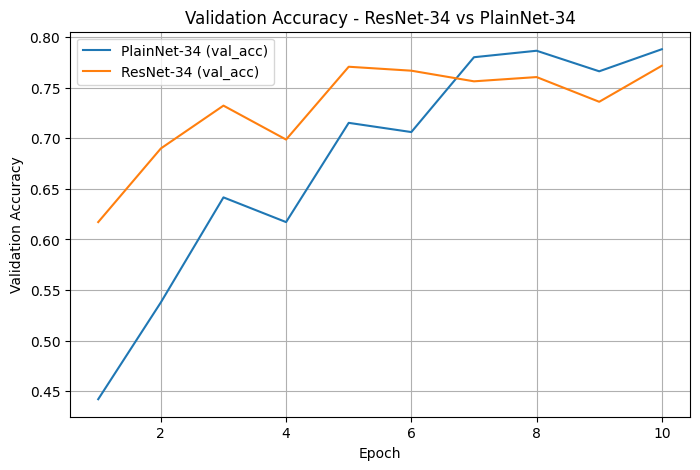

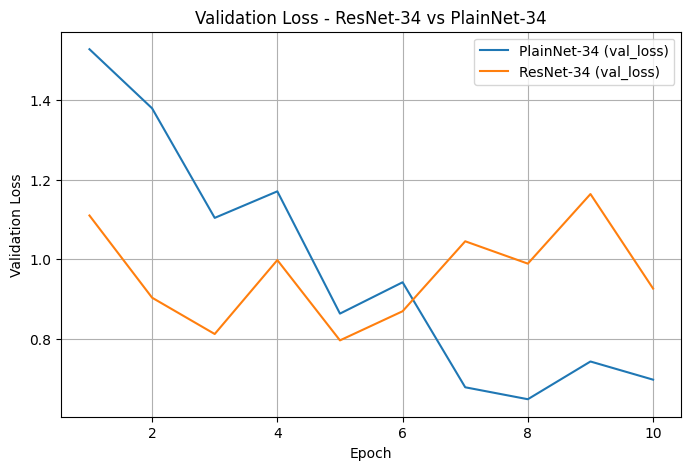

In [22]:
import matplotlib.pyplot as plt

def plot_history_compare(history_plain, history_res, title_suffix="ResNet-34 vs PlainNet-34"):
    # 에포크 인덱스 (1부터 시작)
    epochs = range(1, len(history_plain.history["val_accuracy"]) + 1)

    # 1) 검증 정확도 (Validation Accuracy)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history_plain.history["val_accuracy"], label="PlainNet-34 (val_acc)")
    plt.plot(epochs, history_res.history["val_accuracy"], label="ResNet-34 (val_acc)")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title(f"Validation Accuracy - {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) 검증 손실 (Validation Loss)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history_plain.history["val_loss"], label="PlainNet-34 (val_loss)")
    plt.plot(epochs, history_res.history["val_loss"], label="ResNet-34 (val_loss)")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title(f"Validation Loss - {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()

# 호출
plot_history_compare(history_plain, history_res)


In [ ]:
# plain50 모델을 컴파일합니다.
plain50.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# resnet_50 모델을 컴파일합니다.
resnet_50.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# plain50 모델을 훈련합니다.
history_plain = plain50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# resnet_50 모델을 훈련합니다 (변수명 수정됨).
history_res = resnet_50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
   1563/Unknown 273s 143ms/step - accuracy: 0.1499 - loss: 2.2715

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 301s 160ms/step - accuracy: 0.1499 - loss: 2.2714 - val_accuracy: 0.1889 - val_loss: 3.5867
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 230s 146ms/step - accuracy: 0.2663 - loss: 1.9440 - val_accuracy: 0.2906 - val_loss: 1.9481
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 228s 145ms/step - accuracy: 0.3671 - loss: 1.7087 - val_accuracy: 0.3936 - val_loss: 1.6440
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 263s 167ms/step - accuracy: 0.4293 - loss: 1.5540 - val_accuracy: 0.4656 - val_loss: 1.4700
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 230s 146ms/step - accuracy: 0.4798 - loss: 1.4199 - val_accuracy: 0.5259 - val_loss: 1.3345
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 228s 145ms/step - accuracy: 0.5456 - loss: 1.2712 - val_accuracy: 0.5782 - val_loss: 1.1944
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 228s 145ms/step - accuracy: 0.6005 - loss: 1.1258 - val_accuracy: 0.6003 - val_loss: 1.1597
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 228s 145ms/step - accuracy: 0.6

**GPU 데이터를 다 사용해서 멈춤.**

In [ ]:
import matplotlib.pyplot as plt

def plot_history_compare(history_plain, history_res, title_suffix="ResNet-50 vs PlainNet-50"):
    # 에포크 인덱스 (1부터 시작)
    epochs = range(1, len(history_plain.history["val_accuracy"]) + 1)

    # 1) 검증 정확도 (Validation Accuracy)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history_plain.history["val_accuracy"], label="PlainNet-50 (val_acc)")
    plt.plot(epochs, history_res.history["val_accuracy"], label="ResNet-50 (val_acc)")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title(f"Validation Accuracy - {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) 검증 손실 (Validation Loss)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history_plain.history["val_loss"], label="PlainNet-50 (val_loss)")
    plt.plot(epochs, history_res.history["val_loss"], label="ResNet-50 (val_loss)")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title(f"Validation Loss - {title_suffix}")
    plt.legend()
    plt.grid(True)
    plt.show()

# 호출
plot_history_compare(history_plain, history_res)


프로젝트 최종 목표

ablation study를 통한 모델 성능 비교.

테이블 metric / model

그래프 learning curve- loss,metric

plainnet-34/50 vs resnet-34/50

skip-conection 유무에 따른 성능차이

**성능 비교 요약**

| 모델              | 깊이 | 스킵커넥션 | Best val_acc | Best val_loss | 코멘트                                                    |
| --------------- | -: | :---: | -----------: | ------------: | ------------------------------------------------------ |
| **PlainNet-34** | 34 |   ✗   |   **0.7878** |    **0.6483** | 얕은 Plain은 꽤 잘 학습되고, 검증 정확도도 가장 높게 나옴                   |
| **ResNet-34**   | 34 |   ✔   |       0.7715 |        0.7962 | 학습은 더 잘 맞지만(Train acc↑), 약간 오버피팅 경향                    |
| **PlainNet-50** | 50 |   ✗   |       0.6974 |        0.8745 | 34보다 깊어졌는데 오히려 성능 ↓ → **degradation problem** 재현       |
| **ResNet-50**   | 50 |   ✔   |     ≈0.7603* |      ≈0.9582* | 같은 50층에서 Plain보다 정확도↑, 손실↓ → residual이 깊은 네트워크 학습을 도와줌 |


**34 비교 결과** resnet이


학습 시작은 좋았으나 결론적으로 정밀도 낮고,

로스에서 오버피팅 경향이 있었음.

**50 비교 결과**

resnet이 학습 시작은 좋았으나, 결론 적으로

loss / accuracy 모두 plain 과 결과 적으로 비슷하였다.

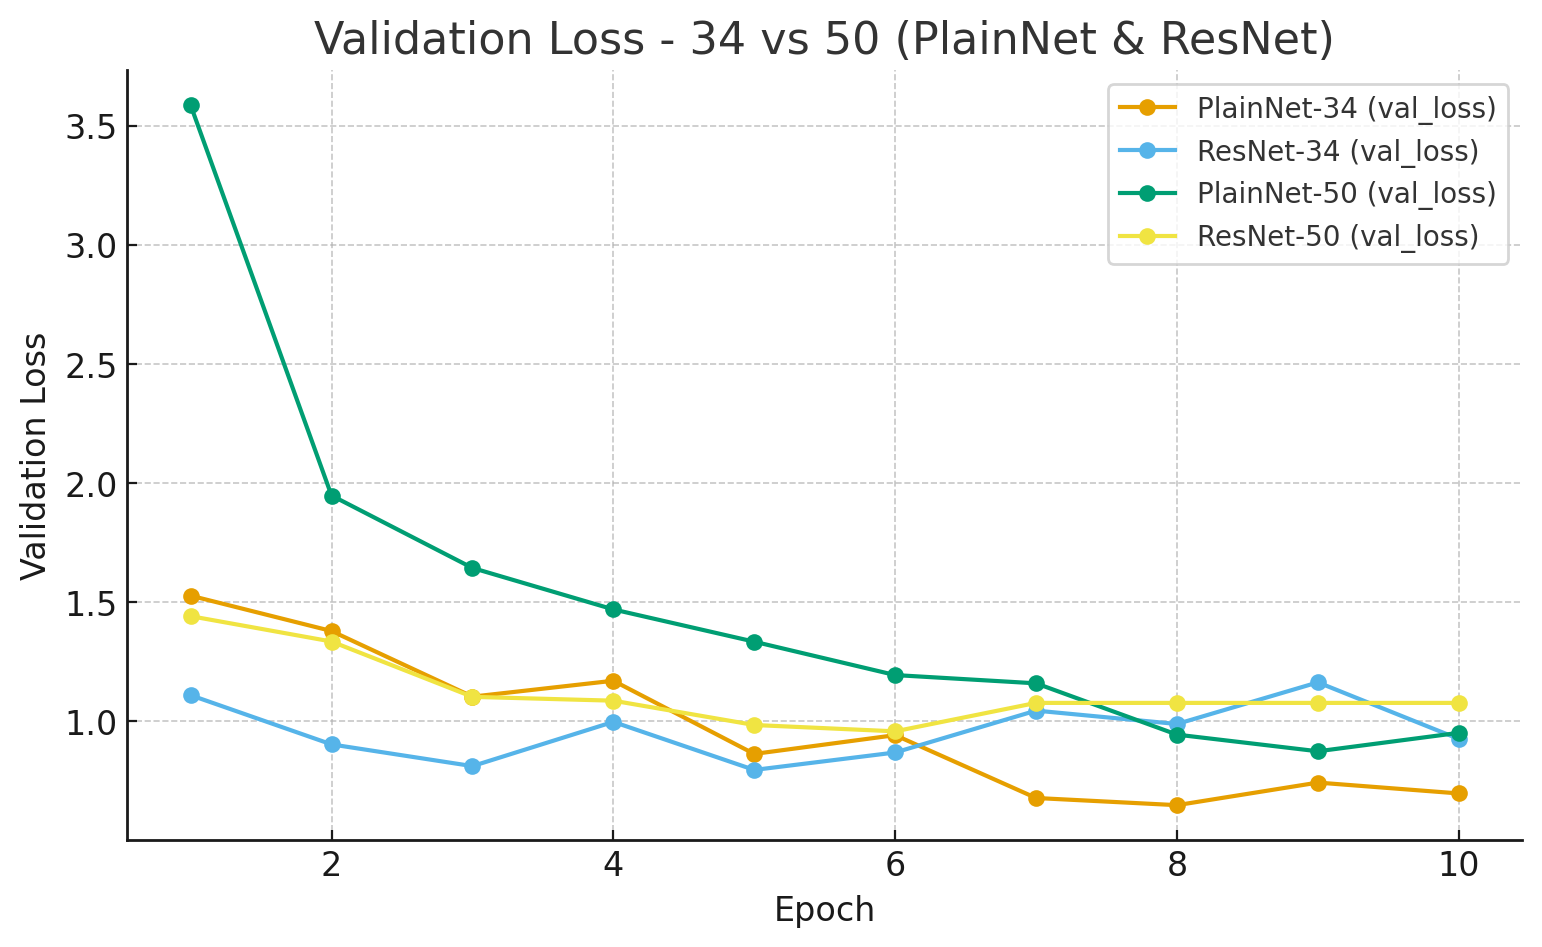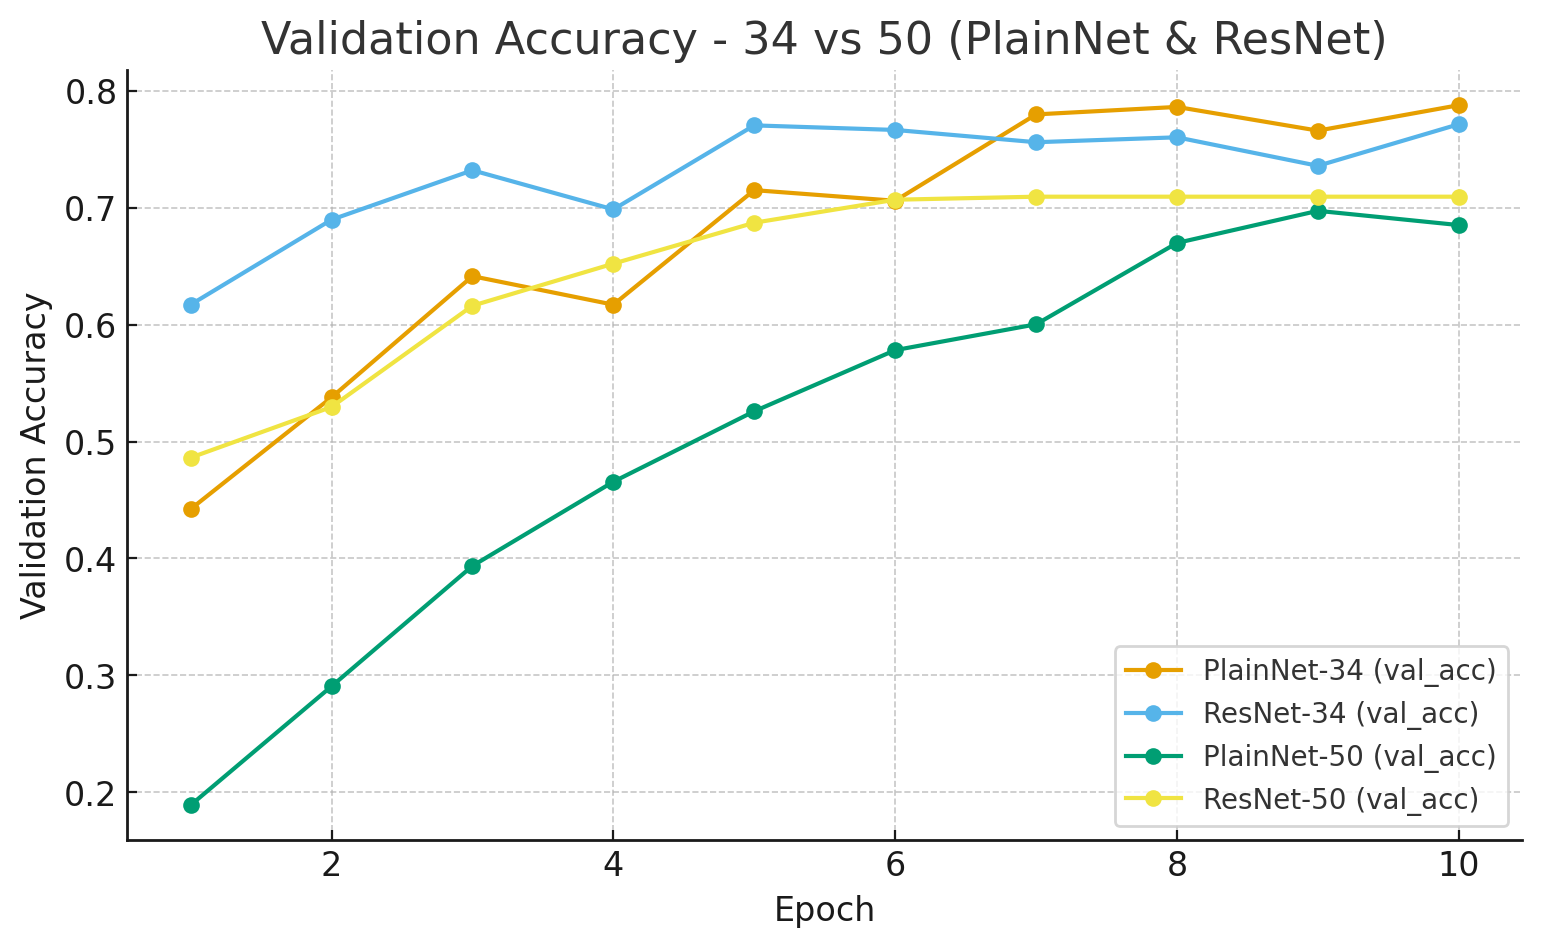

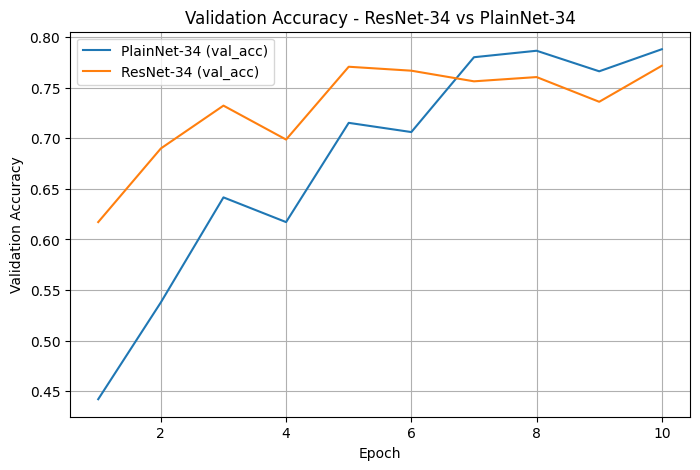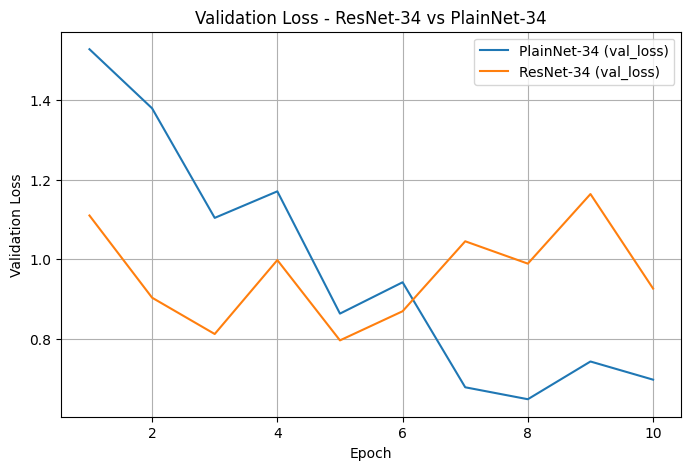

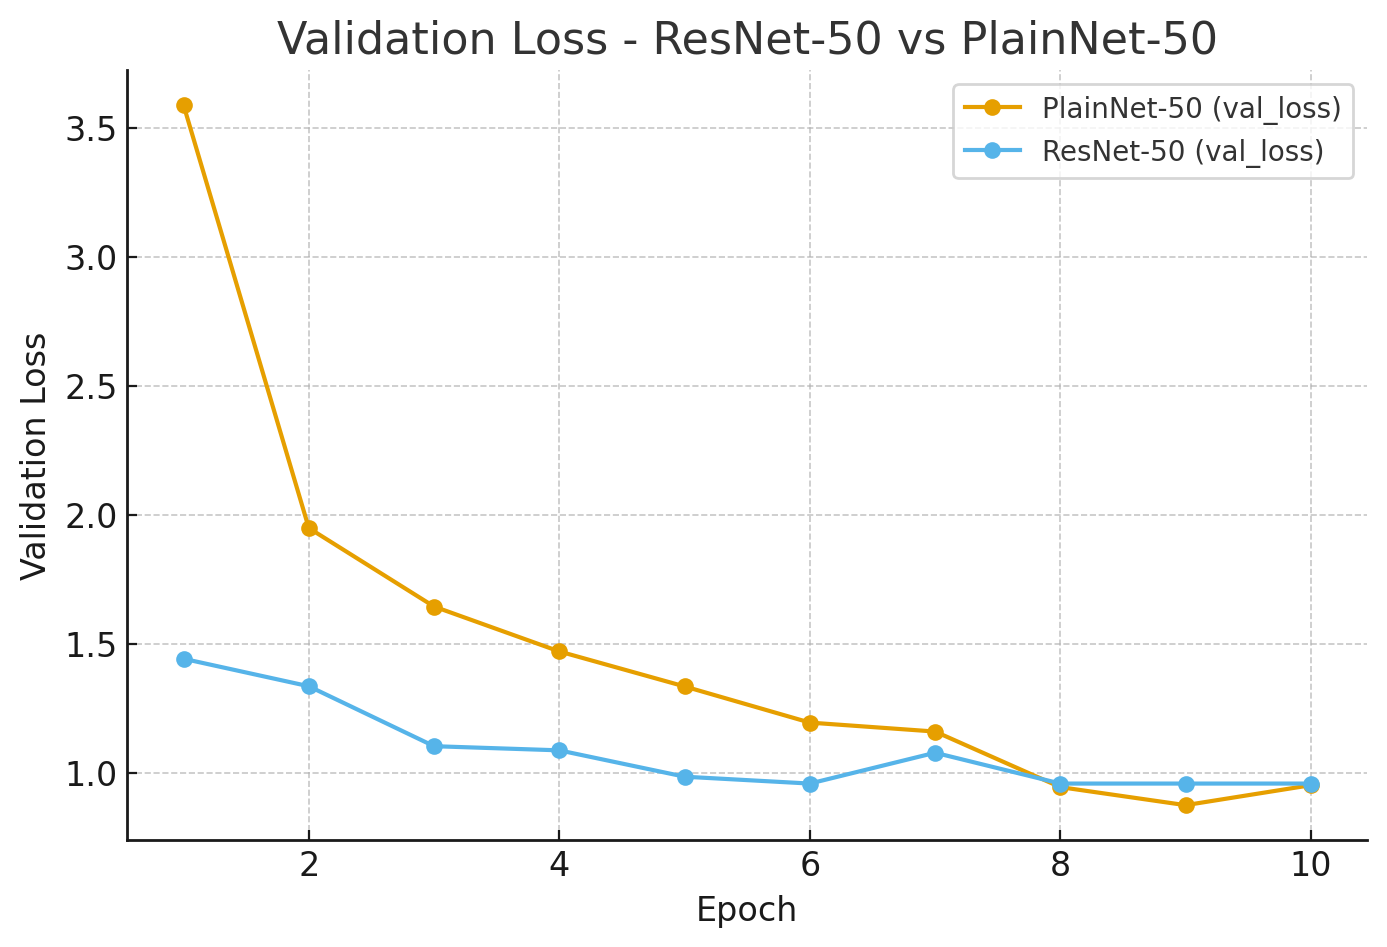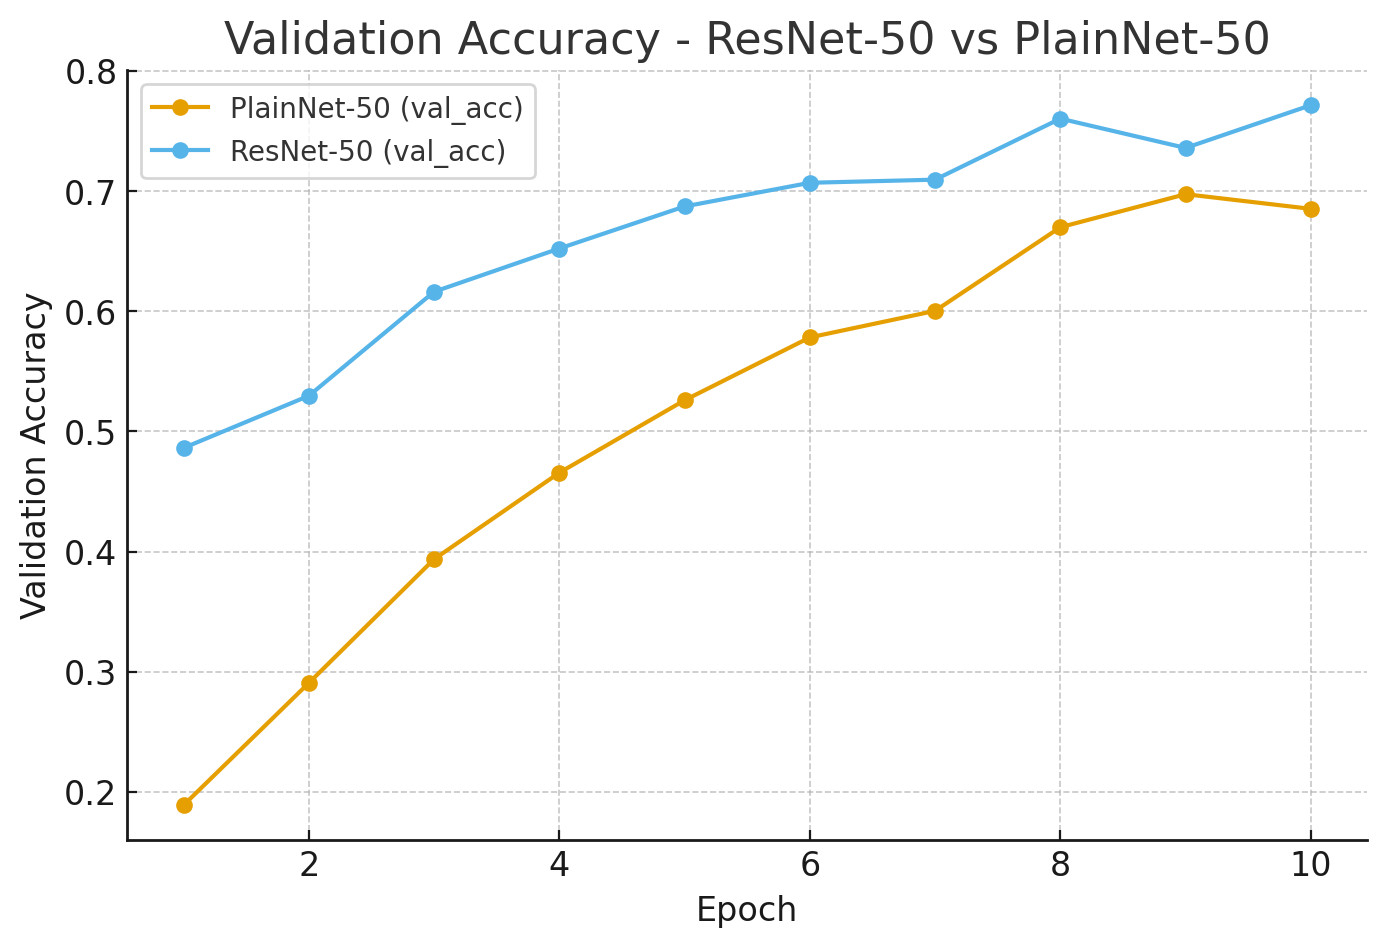

이 실험 결과를 통해서 skip-connection 유무에 따른 성능차이를 알수 있게된게 뭘까?

그리고 이 실험을 한 이유는 무엇을 알기 위해 한 것일까?

In [ ]:
1. 초반 학습 속도가 좋다는 것은
같은 깊이에서도 skip-connection이 있으면 최적화가 더 쉽다는 증거.

2. regularization이 부족하면 오퍼피팅이 생길수 있다는 증거.

3. 레이어가 깊어지면 (50) 성능이 떨어진 degradation problem이 생긴다는 증거.

4. 레이어가 깊어져도 성능이 떨어지지 않고 비교적 학습을 안정적으로 유지한다.

결론.

깊이를 늘리면 plain은 성능이 저하되고,
resnet은 덜 저하 된다.